<a href="https://colab.research.google.com/github/AntonioBorz/CourseWork_ClassicML/blob/main/2_%D0%A0%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D1%8F_%D0%B4%D0%BB%D1%8F_IC50_Borzunov_A_A_CML_%D0%9A%D1%83%D1%80%D1%81%D0%BE%D0%B2%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **2 Регрессия для IC50**

In [ ]:
# Импортируем необходимые библиотеки
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, ElasticNet, HuberRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
!pip install catboost
from catboost import CatBoostRegressor
import joblib
from scipy import stats
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedShuffleSplit

import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.2 MB/s eta 0:00:00


1. Загрузка данных после EDA

In [ ]:
# Загружаем данные
drive.mount('/content/drive')
df = pd.read_excel('/content/drive/MyDrive/EDAprocessed_data.xlsx')

Mounted at /content/drive


In [ ]:
# Проверим датасет
print(f"Количество строк: {len(df)}")
print(f"Количество столбцов: {len(df.columns)}")

# Посмотрим первые строчки
df.head()

Количество строк: 969
Количество столбцов: 178


,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,FpDensityMorgan3,BCUT2D_MWHI,...,log_SI,"IC50, mM","CC50, mM",SI,Charge_Difference,Charge_Stability,EState_Range,Total_Functional_Groups,Functional_Diversity,Complexity_Score
0,5.094096,0.387225,0.387225,0.417362,42.928571,0,0.038844,-0.293526,1.321429,14.822266,...,3.371597,6.239374,175.482382,28.125000,0.332369,0.717222,4.706871,11,4,4.998389
1,3.961417,0.533868,0.533868,0.462473,45.214286,0,0.012887,-0.313407,1.285714,14.975110,...,2.079442,0.771831,5.402819,7.000000,0.326294,0.721593,3.427548,9,3,4.928514
2,2.627117,0.543231,0.543231,0.260923,42.187500,0,0.094802,-0.325573,1.156250,15.353938,...,0.542324,223.808778,161.142320,0.720000,0.420375,0.656801,2.083887,11,4,4.353918
3,5.097360,0.390603,0.390603,0.377846,41.862069,0,0.038844,-0.293526,1.310345,14.821216,...,4.162553,1.705624,107.855654,63.235294,0.332369,0.717223,4.706757,12,4,4.924259
4,5.150510,0.270476,0.270476,0.429038,36.514286,0,0.062897,-0.257239,1.257143,14.831112,...,0.832909,107.131532,139.270991,1.300000,0.320137,0.726050,4.880034,8,3,4.556793


2. Подготовка данных

In [ ]:
# Подготавливаем целевую переменную и признаки
target_ic50 = 'log_IC50, mM'
y_ic50 = df[target_ic50]

In [ ]:
# Исключаем целевые переменные из признаков (кроме 'log_CC50, mM')
exclude_cols = ['IC50, mM', 'log_IC50, mM', 'CC50, mM', 'SI', 'log_SI']
X_cols = [col for col in df.columns if col not in exclude_cols]
X_ic50 = df[X_cols]

In [ ]:
# Разделяем данные
X_train_ic50, X_test_ic50, y_train_ic50, y_test_ic50 = train_test_split(
    X_ic50, y_ic50, test_size=0.2, random_state=42, stratify=pd.qcut(y_ic50, q=5, duplicates='drop')
)

feature_names = X_train_ic50.columns.tolist()

print(f"Размер обучающей выборки: {X_train_ic50.shape}")
print(f"Размер тестовой выборки: {X_test_ic50.shape}")

Размер обучающей выборки: (775, 173)
Размер тестовой выборки: (194, 173)


In [ ]:
# Масштабируем данные (только для моделей, чувствительных к масштабу)
scaler_ic50 = RobustScaler()
X_train_ic50_scaled = scaler_ic50.fit_transform(X_train_ic50)
X_test_ic50_scaled = scaler_ic50.transform(X_test_ic50)

3. Определение и подготовка набора моделей

In [ ]:
# Определяем набор моделей
models_ic50 = {
    'RandomForest': RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=300, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=1000, random_state=42, n_jobs=-1, verbosity=0),
    'CatBoost': CatBoostRegressor(iterations=500, random_state=42, verbose=False),
    'Ridge': Ridge(),
    'ElasticNet': ElasticNet(random_state=42),
    'SVR': SVR(),
    'KNN': KNeighborsRegressor(),
    'MLP': MLPRegressor(random_state=42, max_iter=1000)
}

In [ ]:
# Создаем функцию для оценки моделей - пробовал разные варианты, остановился на этом с кросс-валидацией
def evaluate_models(models, X_train, X_test, y_train, y_test, cv_folds=10):
    """Оцениваем модели с помощью кросс-валидации и тестовой выборки"""
    results = {}
    cv = KFold(n_splits=cv_folds, shuffle=True, random_state=42)

    for name, model in models.items():
        print(f"\nОцениваем модель: {name}")

        try:
            # Кросс-валидация с несколькими метриками
            cv_mae = -cross_val_score(model, X_train, y_train, cv=cv,
                                     scoring='neg_mean_absolute_error', n_jobs=-1)
            cv_r2 = cross_val_score(model, X_train, y_train, cv=cv,
                                   scoring='r2', n_jobs=-1)

            # Обучение модели
            model.fit(X_train, y_train)

            # Предсказания
            y_pred_train = model.predict(X_train)
            y_pred_test = model.predict(X_test)

            # Вычисление метрик
            results[name] = {
                'CV_MAE_mean': cv_mae.mean(),
                'CV_MAE_std': cv_mae.std(),
                'CV_R2_mean': cv_r2.mean(),
                'CV_R2_std': cv_r2.std(),
                'Train_MAE': mean_absolute_error(y_train, y_pred_train),
                'Test_MAE': mean_absolute_error(y_test, y_pred_test),
                'Train_R2': r2_score(y_train, y_pred_train),
                'Test_R2': r2_score(y_test, y_pred_test),
                'Model': model
            }

            # Проверка на переобучение
            r2_diff = results[name]['Train_R2'] - results[name]['Test_R2']
            mae_diff = results[name]['Test_MAE'] - results[name]['Train_MAE']

            if r2_diff > 0.15 or mae_diff > 0.1:
                print(f"Возможно переобучение: ΔR²={r2_diff:.3f}, ΔMAE={mae_diff:.3f}")

        except Exception as e:
            print(f"Ошибка при оценке модели: {str(e)}")

    return results

4. Оценка моделей и выбор лучшей модели

In [ ]:
# Оценка на исходных данных (для деревянных)
tree_models = {k: v for k, v in models_ic50.items() if k not in ['Ridge', 'ElasticNet', 'SVR', 'KNN', 'MLP']}
results_original = evaluate_models(tree_models, X_train_ic50, X_test_ic50, y_train_ic50, y_test_ic50)

# Оценка на масштабированных данных (для линейных моделей)
scaled_models = {k: v for k, v in models_ic50.items() if k in ['Ridge', 'ElasticNet', 'SVR', 'KNN', 'MLP']}
results_scaled = evaluate_models(scaled_models, X_train_ic50_scaled, X_test_ic50_scaled,
                                y_train_ic50, y_test_ic50)

# Объединение результатов
all_results_ic50 = {**results_original, **{f"{k}_scaled": v for k, v in results_scaled.items()}}

# Сводная таблица результатов
results_df_ic50 = pd.DataFrame(all_results_ic50).T
results_df_ic50 = results_df_ic50.sort_values('Test_R2', ascending=False)

print("РЕЗУЛЬТАТЫ МОДЕЛЕЙ ДЛЯ IC50:")
display_cols = ['CV_R2_mean', 'Test_R2', 'Test_MAE', 'CV_MAE_mean']
print(results_df_ic50[display_cols].round(4))


Оцениваем модель: RandomForest
Возможно переобучение: ΔR²=0.347, ΔMAE=0.554

Оцениваем модель: GradientBoosting
Возможно переобучение: ΔR²=0.408, ΔMAE=0.586

Оцениваем модель: XGBoost
Возможно переобучение: ΔR²=0.483, ΔMAE=0.911

Оцениваем модель: CatBoost
Возможно переобучение: ΔR²=0.370, ΔMAE=0.578

Оцениваем модель: Ridge
Возможно переобучение: ΔR²=0.376, ΔMAE=0.211

Оцениваем модель: ElasticNet

Оцениваем модель: SVR

Оцениваем модель: KNN
Возможно переобучение: ΔR²=0.295, ΔMAE=0.298

Оцениваем модель: MLP
Возможно переобучение: ΔR²=198.226, ΔMAE=1.856
РЕЗУЛЬТАТЫ МОДЕЛЕЙ ДЛЯ IC50:
                  CV_R2_mean     Test_R2  Test_MAE CV_MAE_mean
RandomForest        0.535935    0.578404  0.931667    0.981666
CatBoost            0.536226    0.559031  0.940248    0.974533
GradientBoosting    0.507283    0.508161   0.98227     0.99844
XGBoost             0.440848     0.49625  0.966729     1.04738
KNN_scaled          0.310615    0.270255  1.253369    1.212609
Ridge_scaled        0.426078 

In [ ]:
# Выбираем лучшую модель
best_model_name_ic50 = results_df_ic50.index[0]
best_model_ic50 = results_df_ic50.loc[best_model_name_ic50, 'Model']
best_model_type = type(best_model_ic50).__name__

print(f"Лучшая модель: {best_model_name_ic50} ({best_model_type})")
print(f"Test R²: {results_df_ic50.loc[best_model_name_ic50, 'Test_R2']:.4f}")
print(f"Test MAE: {results_df_ic50.loc[best_model_name_ic50, 'Test_MAE']:.4f}")

Лучшая модель: RandomForest (RandomForestRegressor)
Test R²: 0.5784
Test MAE: 0.9317


In [ ]:
# Донастраиваем модель
if 'scaled' in best_model_name_ic50:
    X_train_final, X_test_final = X_train_ic50_scaled, X_test_ic50_scaled
else:
    X_train_final, X_test_final = X_train_ic50, X_test_ic50

# Определяем параметры в зависимости от типа модели
best_model_type = type(best_model_ic50).__name__

if best_model_type == 'CatBoostRegressor':
    param_grid = {
        'iterations': [300, 500, 700],
        'depth': [4, 5, 6],
        'learning_rate': [0.01, 0.05, 0.1],
        'l2_leaf_reg': [1, 3, 5]
    }
elif best_model_type == 'GradientBoostingRegressor':
    param_grid = {
        'n_estimators': [200, 300, 400],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.01, 0.05, 0.1],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
elif best_model_type == 'RandomForestRegressor':
    param_grid = {
        'n_estimators': [300, 400, 500, 600, 700],
        'max_depth': [None, 10, 20, 30, 40],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', 0.5, 0.7],
        'bootstrap': [True, False]
    }
elif best_model_type == 'XGBRegressor':
    param_grid = {
        'n_estimators': [800, 1000, 1200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }
else:  # Для остальных моделей используем упрощенную настройку
    param_grid = {
        'alpha': [0.1, 0.5, 1.0, 2.0],
        'fit_intercept': [True, False]
    } if best_model_type in ['Ridge', 'ElasticNet'] else {}

    # Для моделей, которые не поддерживают настройку
    if not param_grid:
        tuned_model_ic50 = best_model_ic50
        y_pred_tuned = best_model_ic50.predict(X_test_final)
        tuned_r2 = r2_score(y_test_ic50, y_pred_tuned)
        tuned_mae = mean_absolute_error(y_test_ic50, y_pred_tuned)

        print(f"\nРезультаты базовой модели:")
        print(f"Test R²: {tuned_r2:.4f}")
        print(f"Test MAE: {tuned_mae:.4f}")

        # Сравнение не требуется, так как модель не настраивалась
        improvement = 0.0
        final_model_ic50 = tuned_model_ic50

# Если для модели определены параметры настройки
if 'param_grid' in locals() and param_grid:
    random_search = RandomizedSearchCV(
        estimator=best_model_ic50,
        param_distributions=param_grid,
        n_iter=30,
        cv=3,
        scoring='r2',
        n_jobs=-1,
        random_state=42,
        verbose=1
    )

    random_search.fit(X_train_final, y_train_ic50)
    tuned_model_ic50 = random_search.best_estimator_

    # Оценка настроенной модели
    y_pred_tuned = tuned_model_ic50.predict(X_test_final)
    tuned_r2 = r2_score(y_test_ic50, y_pred_tuned)
    tuned_mae = mean_absolute_error(y_test_ic50, y_pred_tuned)

    print(f"\nРезультаты после настройки:")
    print(f"Лучшие параметры: {random_search.best_params_}")
    print(f"Test R²: {tuned_r2:.4f}")
    print(f"Test MAE: {tuned_mae:.4f}")

    # Сравнение с исходной моделью
    original_r2 = results_df_ic50.loc[best_model_name_ic50, 'Test_R2']
    improvement = tuned_r2 - original_r2
    print(f"Улучшение R²: {improvement:+.4f}")

    final_model_ic50 = tuned_model_ic50

Fitting 3 folds for each of 30 candidates, totalling 90 fits

Результаты после настройки:
Лучшие параметры: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.5, 'max_depth': 30, 'bootstrap': True}
Test R²: 0.5800
Test MAE: 0.9401
Улучшение R²: +0.0016


5. Анализ результатов и оценка важности признаков

In [ ]:
# Создаем функцию для получения важности признаков
def get_feature_importance(model, feature_names, X_test, y_test):
    """Анализ важности признаков для различных типов моделей"""
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importance = np.abs(model.coef_)
        if len(importance.shape) > 1:
            importance = np.mean(importance, axis=0)
    else:
        perm_importance = permutation_importance(
            model, X_test, y_test,
            n_repeats=10,
            random_state=42,
            n_jobs=-1
        )
        importance = perm_importance.importances_mean

    # Нормализуем важность для наглядности
    importance = 100.0 * (importance / importance.max())

    return pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)

# Анализ важности признаков
feature_importance_ic50 = get_feature_importance(
    final_model_ic50,
    feature_names,
    X_test_final,
    y_test_ic50
)

# Выводим топ-10 признаков
print("ТОП-10 ВАЖНЫХ ПРИЗНАКОВ ДЛЯ IC50:")
top_features = feature_importance_ic50.head(10)
print(top_features.to_string(index=False))

ТОП-10 ВАЖНЫХ ПРИЗНАКОВ ДЛЯ IC50:
      feature  importance
 log_CC50, mM  100.000000
  VSA_EState8   11.723192
  VSA_EState4   10.727518
BCUT2D_LOGPHI    7.543109
   SlogP_VSA5    5.417904
     BalabanJ    3.345340
 BCUT2D_MRLOW    3.190104
 BCUT2D_MWLOW    3.042690
          qed    2.982498
 BCUT2D_CHGHI    2.957014


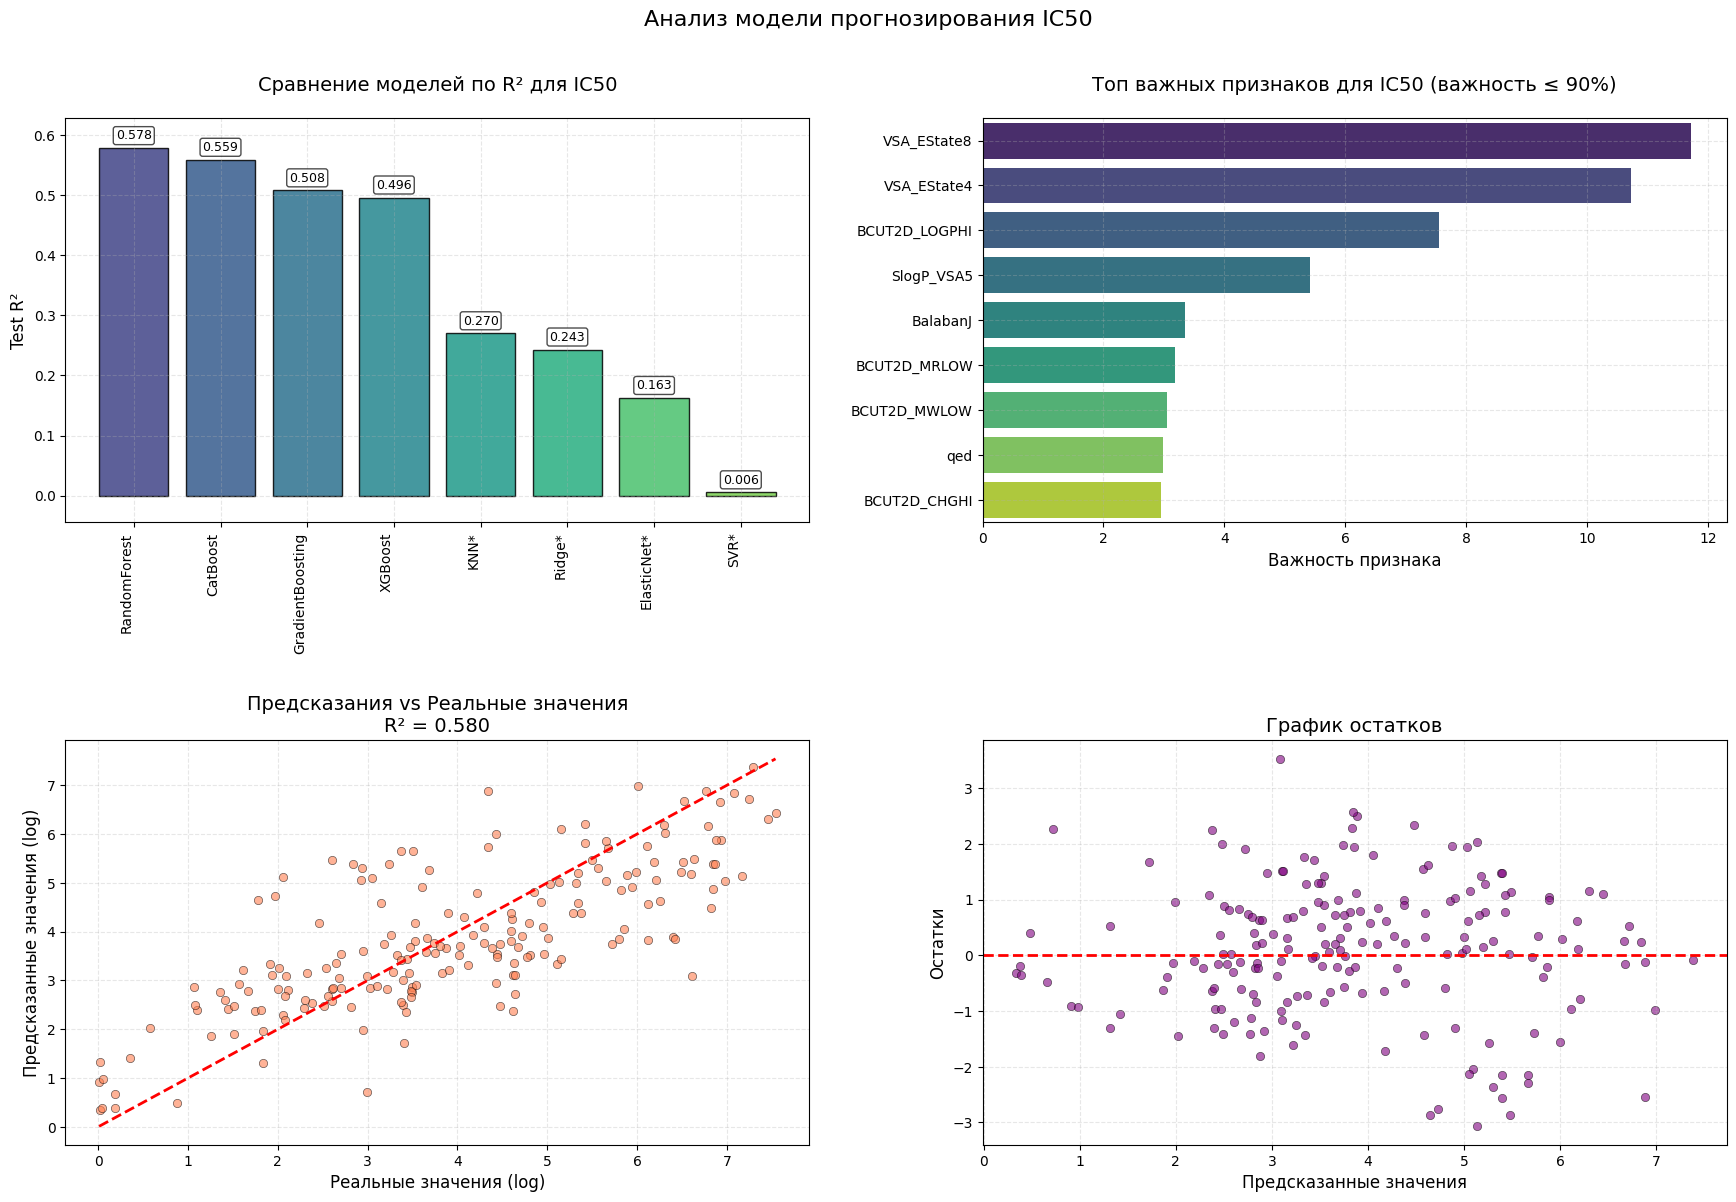

In [ ]:
# Визуализация результатов
plt.figure(figsize=(18, 12))

# Сравнение моделей по R²
plt.subplot(2, 2, 1)
top_models = results_df_ic50.head(8)
model_names = [name.replace('_scaled', '*') for name in top_models.index]
r2_scores = top_models['Test_R2'].values
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(model_names)))
bars = plt.bar(range(len(model_names)), r2_scores, color=colors, edgecolor='black', alpha=0.85)
plt.xticks(range(len(model_names)), model_names, ha='right', rotation=90, fontsize=10)
plt.ylabel('Test R²', fontsize=12)
plt.title('Сравнение моделей по R² для IC50', fontsize=14, pad=20)
plt.grid(True, alpha=0.3, linestyle='--')
plt.ylim(min(r2_scores) - 0.05, max(r2_scores) + 0.05)

# Добавляем значения на столбцы
for bar, score in zip(bars, r2_scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{score:.3f}',
             ha='center', va='bottom',
             fontsize=9,
             bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2'))

# Важность признаков
plt.subplot(2, 2, 2)
# Фильтруем признаки с важностью <= 90%
top_features_filtered = top_features[top_features['importance'] <= 90]

if not top_features_filtered.empty:
    sns.barplot(
        x='importance',
        y='feature',
        data=top_features_filtered,
        hue='feature',
        palette='viridis',
        dodge=False,
        legend=False
    )
    plt.xlabel('Важность признака', fontsize=12)
    plt.ylabel('')
    plt.title('Топ важных признаков для IC50 (важность ≤ 90%)', fontsize=14, pad=20)
    plt.grid(True, alpha=0.3, linestyle='--')

# Предсказания vs Реальные значения
plt.subplot(2, 2, 3)
plt.scatter(y_test_ic50, y_pred_tuned, alpha=0.6, color='coral', edgecolor='k', linewidth=0.5)
plt.plot([min(y_test_ic50), max(y_test_ic50)], [min(y_test_ic50), max(y_test_ic50)],
         'r--', lw=2)
plt.xlabel('Реальные значения (log)', fontsize=12)
plt.ylabel('Предсказанные значения (log)', fontsize=12)
plt.title(f'Предсказания vs Реальные значения\nR² = {tuned_r2:.3f}', fontsize=14)
plt.grid(True, alpha=0.3, linestyle='--')

# Остатки
plt.subplot(2, 2, 4)
residuals = y_test_ic50 - y_pred_tuned
plt.scatter(y_pred_tuned, residuals, alpha=0.6, color='purple', edgecolor='k', linewidth=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Предсказанные значения', fontsize=12)
plt.ylabel('Остатки', fontsize=12)
plt.title('График остатков', fontsize=14)
plt.grid(True, alpha=0.3, linestyle='--')

# Общие настройки
plt.tight_layout(pad=3.0)
plt.suptitle('Анализ модели прогнозирования IC50', fontsize=16, y=1.02)
plt.show()

In [ ]:
# Сохраняем модель
joblib.dump(final_model_ic50, 'best_model_ic50.pkl')

# Сохраняем результаты
results_df_ic50.to_csv('ic50_model_results.csv')
top_features.to_csv('ic50_top_features.csv', index=False)
print("Результаты сохранены!")

Результаты сохранены!
